<a href="https://colab.research.google.com/github/SamruddhiMhatre/dlaicourse/blob/master/Binary_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [4]:
print(tf.__version__)

2.5.0


Importing data from directory

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 6s 0us/step


In [6]:
os.listdir(dataset_dir)

['imdb.vocab', 'README', 'test', 'imdbEr.txt', 'train']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)


['urls_neg.txt',
 'unsup',
 'labeledBow.feat',
 'urls_pos.txt',
 'urls_unsup.txt',
 'neg',
 'pos',
 'unsupBow.feat']

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)


In [10]:
remove_dir

'./aclImdb/train/unsup'

[Text Data from Directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory)

In [19]:
batch_size = 32
seed = 42

# train
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    seed = seed,
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training'
)

print('Number of batches in training set: ', tf.data.experimental.cardinality(raw_train_ds), '\n')


# validation 
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    seed = seed,
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation'
)

print('Number of batches in validation set: ', tf.data.experimental.cardinality(raw_val_ds),'\n')


# test 
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size
)

print('Number of batches in testing set: ', tf.data.experimental.cardinality(raw_test_ds))

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Number of batches in training set:  tf.Tensor(625, shape=(), dtype=int64) 

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Number of batches in validation set:  tf.Tensor(157, shape=(), dtype=int64) 

Found 25000 files belonging to 2 classes.
Number of batches in testing set:  tf.Tensor(782, shape=(), dtype=int64)


In [37]:
for text_batch, label_batch in raw_train_ds.take(2):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'s a 

In [39]:
train_texts = []
train_labels = []

for text_batch, label_batch in raw_train_ds:
  train_texts.append(text_batch)
  train_labels.append(label_batch)


val_texts = []
val_labels = []

for text_batch, label_batch in raw_val_ds:
  val_texts.append(text_batch)
  val_labels.append(label_batch)


test_texts = []
test_labels = []

for text_batch, label_batch in raw_test_ds:
  test_texts.append(text_batch)
  test_labels.append(label_batch)

In [36]:
print('Lenght of train set:', len(train_texts))
print('Train set data type:', type(train_texts))
print('Train set shape:', np.asarray(train_texts).shape)

Lenght of train set: 625
Train set data type:  <class 'list'>
Train set shape:  (625, 32)


In [42]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [38]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

The below code snippet does not work on tensorflow object, therefore Tokenizer cannot be used for this purpose. 

In [45]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_texts) # error line: AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'lower'
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

AttributeError: ignored

In [47]:
lowercase = tf.strings.lower(train_texts)
lowercase

<tf.Tensor: shape=(625, 32), dtype=string, numpy=
array([[b'great movie - especially the music - etta james - "at last". this speaks volumes when you have finally found that special someone.',
        b"i am shocked. shocked and dismayed that the 428 of you imdb users who voted before me have not given this film a rating of higher than 7. 7?!?? - that's a c!. if i could give fobh a 20, i'd gladly do it. this film ranks high atop the pantheon of modern comedy, alongside half baked and mallrats, as one of the most hilarious films of all time. if you know _anything_ about rap music - you must see this!! if you know nothing about rap music - learn something!, and then see this! comparisons to 'spinal tap' fail to appreciate the inspired genius of this unique film. if you liked bob roberts, you'll love this. watch it and vote it a 10!",
        b'what a lovely heart warming television movie. the story tells of a little five year old girl who has lost her daddy and finds it impossible to cop

[Regular Expression in Tensorflow](https://www.tensorflow.org/api_docs/python/tf/strings/regex_replace)

In [52]:
def textStandardization(text):
  text = tf.strings.lower(text)
  cleantext = tf.strings.regex_replace(text,"<[^>]+>", " ")
  return cleantext


clean = textStandardization(train_texts)
clean

<tf.Tensor: shape=(625, 32), dtype=string, numpy=
array([[b'great movie - especially the music - etta james - "at last". this speaks volumes when you have finally found that special someone.',
        b"i am shocked. shocked and dismayed that the 428 of you imdb users who voted before me have not given this film a rating of higher than 7. 7?!?? - that's a c!. if i could give fobh a 20, i'd gladly do it. this film ranks high atop the pantheon of modern comedy, alongside half baked and mallrats, as one of the most hilarious films of all time. if you know _anything_ about rap music - you must see this!! if you know nothing about rap music - learn something!, and then see this! comparisons to 'spinal tap' fail to appreciate the inspired genius of this unique film. if you liked bob roberts, you'll love this. watch it and vote it a 10!",
        b'what a lovely heart warming television movie. the story tells of a little five year old girl who has lost her daddy and finds it impossible to cop

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

[TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization)

In [53]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=textStandardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [56]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [66]:
text_batch[0].shape.as_list()

[]

In [62]:
text_batch, label_batch = next(iter(raw_train_ds))
tf.expand_dims(text_batch[0],-1).shape.as_list()

[1]

In [82]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [70]:
# retrieve a batch (of 32 reviews and labels) from the dataset. axis = 0
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"My children watch the show everyday that its on. Its a great program for younger children. However they need to stop showing re-runs and do some more actual shows and get rid of Rooney's and Deedee's YELLOW TEETH. Moe is the only Doodle bop with clean white pearlie teeth and the children notice these things and ask if the 2 don't ever brush their teeth? Does the show ever make its way to the United States and if so where can we find its schedule at. And one other thing if we might be able to add. Moe you need to stop hiding so much. Sometimes when you pop up out of no where you scare the younger children and whats with the pulling of the rope? What does that signify? other then getting wet all the time. They need to add newer things to their show instead of the same ole same ole. Kids loose interest that way.", shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  52,  572,  109,    2,  134, 3172,   11,   83,  

In [71]:
# retrieve a batch (of 32 reviews and labels) from the dataset. axis = 1
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'What a lovely heart warming television movie. The story tells of a little five year old girl who has lost her daddy and finds it impossible to cope. Her mother is also very distressed ..only a miracle can alleviate their unhappiness.Which all viewers hope will materialise. Samantha Mathis is brilliant as the little girl\'s mum ,as she was as the nanny in" Jack and Sarah",worth watching if you like both Samantha Mathis and happy; year tear jerking movies! Ellen Burstyn is, as, always a delightful grandmother in this tender and magnificently acted movie. Jodelle Ferland (the little five year old) is charming and a most convincing young actress. The film is based on a true story which makes it so touching."Mermaid" is a tribute to the milk of human kindness which is clearly illustrated and clearly is still all around us in this difficult world we live in. "Mermaid" gives us all hope ,by realising that there a lot of lovely people in the world with lot\'s of love to give

In [83]:
# retrieve a batch (of 32 reviews and labels) from the dataset. axis = -1
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'I try to be very objective when I view a low budget movie. I also apply a lower weight to independent and low budget productions versus the big budget productions. I expect near flawlessness from big budget productions and their studios. Therefore I apply tougher criteria to the major studio releases. But this movie was just a dud. Period. The premise was terrible. The main character, Mary Gordano (Alicia Silverstone), was unbelievable as a high school senior with an unquenchable desire to solve crimes. There was not enough depth in her character or her acting that pulled you into her world. Also, to make this movie more mysterious, the lighting in certain scenes did not set the mood, especially in the warehouse.<br /><br />Once again another disappointing movie that I could only give three points to.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   9,  318,    6,   27,   50, 7164,   49,    9,  792,    

In [84]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [85]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [76]:
train_ds

<PrefetchDataset shapes: ((None, 250), (None,)), types: (tf.int64, tf.int32)>

In [78]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 9999 ---> ",vectorize_layer.get_vocabulary()[9999])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  concept
 9999 --->  villains.
Vocabulary size: 10000


In [86]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [88]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 13s 20ms/step - loss: 0.6710 - binary_accuracy: 0.6734 - val_loss: 0.6312 - val_binary_accuracy: 0.7582
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5723 - binary_accuracy: 0.7840 - val_loss: 0.5246 - val_binary_accuracy: 0.8064
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4733 - binary_accuracy: 0.8277 - val_loss: 0.4474 - val_binary_accuracy: 0.8388
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4054 - binary_accuracy: 0.8546 - val_loss: 0.3990 - val_binary_accuracy: 0.8532
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3610 - binary_accuracy: 0.8680 - val_loss: 0.3683 - val_binary_accuracy: 0.8614
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3282 - binary_accuracy: 0.8812 - val_loss: 0.3476 - val_binary_accuracy: 0.8656
Epoch 7/10
625/625 [==============================] - 5s 8ms/s

In [89]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.2478 - binary_accuracy: 0.9073
Loss:  0.247764453291893
Accuracy:  0.9073200225830078


In [93]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

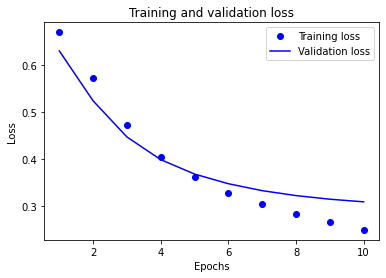

In [94]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

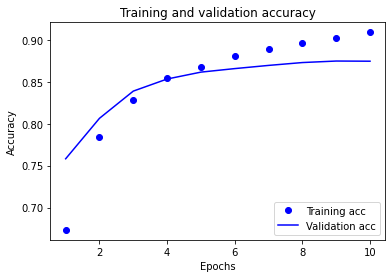

In [95]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [99]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.2478 - accuracy: 0.9073
0.9073200225830078


In [102]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was bad in every possible way"
]

predictions = export_model.predict(examples)

In [106]:
for review, prediction in zip(examples, predictions):
  if prediction >= 0.5:
    print(review,': Positive review')
  else:
    print(review,': Negatvie review')

The movie was great! : Positive review
The movie was okay. : Positive review
The movie was bad in every possible way : Negatvie review
